# Named Entity Recognition (NER) Demo

This notebook demonstrates the evaluation and inference of a pre-trained NER model trained to identify mountain names in text.

- **Model**: `sofibrezden/ner-model-mountains` [link](https://huggingface.co/sofibrezden/ner-model-mountains)
- **Task**: Identify mountain names in text (NER)

We will:
1. Evaluate the model's performance on a test dataset.
2. Perform inference on custom input texts.


# Evaluate the model's performance on a test dataset.

In [1]:
from datasets import load_from_disk
from transformers import AutoModelForTokenClassification, AutoTokenizer, Trainer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from model_inference import predict_entities

In [2]:
# Load the model and tokenizer
ner_model = AutoModelForTokenClassification.from_pretrained('sofibrezden/ner-model-mountains')
ner_tokenizer = AutoTokenizer.from_pretrained('sofibrezden/ner-model-mountains')


In [3]:
def tokenize_and_align_labels(dataset_samples):
    tokenized_outputs = ner_tokenizer(
        dataset_samples["tokens"], truncation=True, padding=True, is_split_into_words=True
    )
    all_entity_labels = dataset_samples["fine_ner_tags"]
    aligned_labels = []

    for index, entity_labels in enumerate(all_entity_labels):
        word_indices = tokenized_outputs.word_ids(index)
        aligned_labels.append(align_labels_with_tokens(entity_labels, word_indices))

    # Add padding for the labels as well
    max_len = max(len(label) for label in aligned_labels)
    padded_labels = [label + [-100] * (max_len - len(label)) for label in aligned_labels]
    
    tokenized_outputs["labels"] = padded_labels
    return tokenized_outputs

def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            new_labels.append(label)
    return new_labels

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    true_labels = [label[label != -100] for label in labels]
    true_preds = [pred[label != -100] for pred, label in zip(preds, labels)]

    all_labels = np.concatenate(true_labels)
    all_preds = np.concatenate(true_preds)

    precision_class1 = precision_score(all_labels, all_preds, labels=[1], average="macro", zero_division=0)
    recall_class1 = recall_score(all_labels, all_preds, labels=[1], average="macro", zero_division=0)
    f1_class1 = f1_score(all_labels, all_preds, labels=[1], average="macro", zero_division=0)

    return {"precision_class1": precision_class1, "recall_class1": recall_class1, "f1_class1": f1_class1}

In [4]:
# Load the test dataset
test_loaded = load_from_disk('./data/test_data')

In [5]:
trainer = Trainer(
    model=ner_model,
    tokenizer=ner_tokenizer,
    compute_metrics=compute_metrics
)

# Tokenize and align the test dataset with padding
tokenized_test = test_loaded.map(
    tokenize_and_align_labels,
    batched=True
)

Map:   0%|          | 0/905 [00:00<?, ? examples/s]

In [6]:
# Evaluate the model on the tokenized test dataset
test_results = trainer.evaluate(tokenized_test)
print(f'Precision = {test_results["eval_precision_class1"]}')
print(f'Recall = {test_results["eval_recall_class1"]}')
print(f'F1-score = {test_results["eval_f1_class1"]}')

Precision = 0.9052725647899911
Recall = 0.8074930251096054
F1-score = 0.8535917421529386


# Visualization

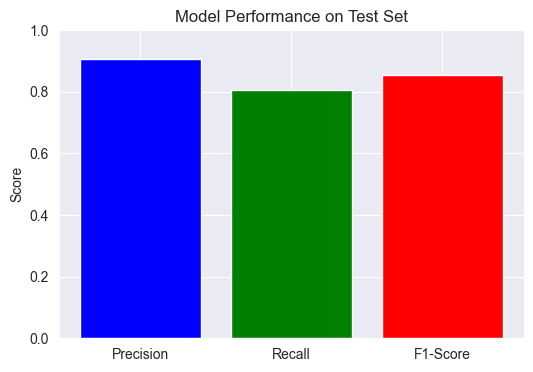

In [7]:
# Extract metrics from the test results
precision = test_results["eval_precision_class1"]
recall = test_results["eval_recall_class1"]
f1_score_value  = test_results["eval_f1_class1"]

metrics = [precision, recall, f1_score_value ]
labels = ['Precision', 'Recall', 'F1-Score']

# Plot the metrics
plt.figure(figsize=(6, 4))
plt.bar(labels, metrics, color=['blue', 'green', 'red'])
plt.title('Model Performance on Test Set')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

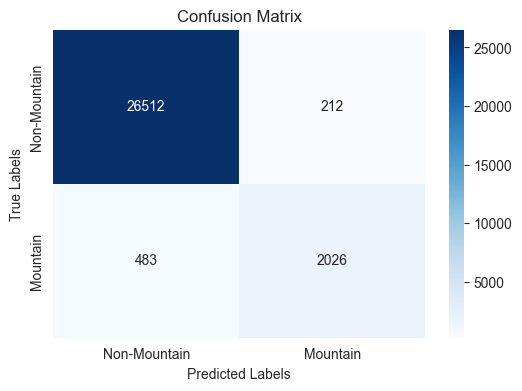

In [8]:
def plot_confusion_matrix(predictions, true_labels):
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Mountain', 'Mountain'], yticklabels=['Non-Mountain', 'Mountain'])
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.title('Confusion Matrix')
    plt.show()

predictions_output = trainer.predict(tokenized_test)
preds = predictions_output.predictions.argmax(-1)  # Get the predicted classes
true_labels = predictions_output.label_ids          # Get the true labels

valid_true_labels = true_labels[true_labels != -100]
valid_preds = preds[true_labels != -100]

# Plot the confusion matrix
plot_confusion_matrix(valid_preds, valid_true_labels)

The model is highly accurate at identifying non-mountain entities, but it misses some mountain entities, resulting in more false negatives than false positives. The model could benefit from improvements in recognizing all mountains, though overall performance is high.

In [9]:
pred_probs = predictions_output.predictions
valid_true_labels = true_labels[true_labels != -100]
valid_pred_probs = pred_probs[true_labels != -100, 1]  

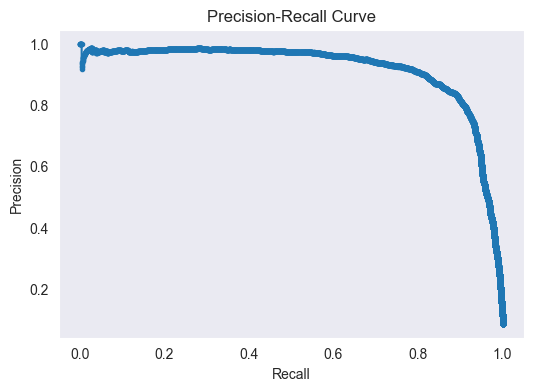

In [10]:
def plot_precision_recall_curve(true_labels, predicted_probs):
    precision, recall, _ = precision_recall_curve(true_labels, predicted_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.show()
    
plot_precision_recall_curve(valid_true_labels, valid_pred_probs)

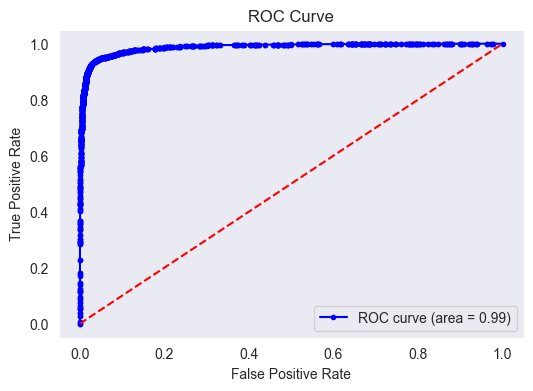

In [11]:
def plot_roc_curve(true_labels, predicted_probs):
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', color='b', marker='.')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')  
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(valid_true_labels, valid_pred_probs)

Both the precision-recall curve and the ROC curve suggest that the model is performing very well in identifying mountain names. The precision-recall curve shows that the model maintains high precision for most recall values. The ROC curve shows excellent model performance with an AUC of 0.99, indicating that the model has a high true positive rate while maintaining a low false positive rate. The curve's proximity to the top-left corner demonstrates strong discriminative ability between mountain and non-mountain entities.

# Inference and Entity Highlighting

In [12]:
texts = [
    "I love the Rocky Mountains and Mount Everest.",
    "I spent days climbing on Mont Blanc",
    "Mount Fuji is a famous mountain in Japan.",
    "The Alps stretch across eight countries in Europe."
]

for text in texts:
    print(f"Original: {text}")
    highlighted = predict_entities(text, ner_model, ner_tokenizer)
    print(f"Highlighted: {highlighted}\n")

Original: I love the Rocky Mountains and Mount Everest.
Highlighted: [CLS] I love the **Rocky** **Mountains** and **Mount** **Everest**. [SEP]

Original: I spent days climbing on Mont Blanc
Highlighted: [CLS] I spent days climbing on **Mont** **Blanc** [SEP]

Original: Mount Fuji is a famous mountain in Japan.
Highlighted: [CLS] **Mount** **Fuji** is a famous mountain in Japan. [SEP]

Original: The Alps stretch across eight countries in Europe.
Highlighted: [CLS] The **Alps** stretch across eight countries in Europe. [SEP]
